In [119]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
print(f"Using device: {device}")

Using device: cuda


In [111]:
# Galerkin model optimization for a given k

def galekin_residual(t, theta):
    """
    Compute the residual f_theta(t) for the Galerkin ansatz.
    
    The ansatz is:
      x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²,
    with parameters theta = (ω, α, β, γ).
    
    The residual (obtained after computing the derivatives and plugging
    into the rewritten ODE)
      2 ω² (x̃(t)-1) * [2α sin²(ωt) - α - 32β sin⁴(ωt) + 32β sin²(ωt) - 4β + 18γ sin²(3ωt) - 9γ]
      + x̃(t) - x̃(t)²
    is returned.
    """
    omega, alpha, beta, gamma = theta

    sin_omega = torch.sin(omega * t)
    sin_2omega = torch.sin(2 * omega * t)
    sin_3omega = torch.sin(3 * omega * t)
    
    # Compute the Galerkin ansatz for x
    x_t = alpha * sin_omega**2 + beta * sin_2omega**2 + gamma * sin_3omega**2

    factor1 = x_t - 1.0
    term_sin2 = sin_omega**2
    term_sin4 = sin_omega**4
    term_sin2_3 = torch.sin(3 * omega * t)**2  # same as sin_3omega**2

    factor2 = (2 * alpha * term_sin2 - alpha
               - 32 * beta * term_sin4 + 32 * beta * term_sin2 - 4 * beta
               + 18 * gamma * term_sin2_3 - 9 * gamma)

    # Residual f_theta(t)
    f_t = 2 * omega**2 * factor1 * factor2 + x_t - x_t**2
    return f_t

def optimize_theta_for_k(k_val, N=100, n_iter=1000, lr=1e-2, print_every=500):
    """
    For a given k, optimize the Galerkin parameters theta = (omega, alpha, beta, gamma)
    to minimize the squared error and return the best theta based on lowest loss.
    """
    # Create time points
    t_points = torch.linspace(0, 5 * np.pi, N, device=device)
    
    # Initial guess for theta
    theta = torch.tensor([1.0, k_val, k_val/2, k_val/4], device=device, requires_grad=True)
    
    optimizer = optim.Adam([theta], lr=lr)
    
    best_loss = float('inf')
    best_theta = None
    
    for it in range(n_iter):
        optimizer.zero_grad()
        f_vals = galekin_residual(t_points, theta)
        loss = torch.mean((f_vals - k_val)**2)
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_theta = theta.detach().clone()
        
        if (it+1) % print_every == 0:
            print(f"[k = {k_val:.3f}] Iter {it+1:4d}: loss = {loss.item():.4e}   theta = {theta.data.cpu().numpy()}")
    
    return best_theta, best_loss

# For demonstration, choose one value of k (e.g. k=0.1)
k_example = 0.1
best_theta, best_loss = optimize_theta_for_k(k_example)

[k = 0.100] Iter  500: loss = 1.4472e-08   theta = [ 4.67141807e-01  2.26781286e-01  6.77833017e-04 -1.23910163e-05]
[k = 0.100] Iter 1000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]


In [112]:
# Compare Galerkin model with a Runge-Kutta solution

def runge_kutta_ode(k, dt=0.001, T=5*np.pi):
    """
    Solve the original ODE using RK4.
    
    The ODE is given in the form:
       (1-x) x'' - x² + x = k,
    which is equivalent to
       x'' = [k + x² - x] / (1 - x),
    with initial conditions x(0)=0 and x'(0)=0.
    
    This function returns time points and the computed x(t).
    """
    # Number of time steps
    N_steps = int(T / dt) + 1
    t = np.linspace(0, T, N_steps)
    x = np.zeros(N_steps)
    v = np.zeros(N_steps)  # velocity = x'
    
    # Define the derivative function
    def f(x, v):
        # Avoid division by zero (if x is close to 1)
        denom = 1 - x
        if np.abs(denom) < 1e-6:
            denom = np.sign(denom)*1e-6
        return (k + x**2 - x) / denom
    
    for i in range(N_steps-1):
        # RK4 integration for second-order ODE
        # Step for x
        k1x = v[i]
        k1v = f(x[i], v[i])
        
        k2x = v[i] + 0.5 * dt * k1v
        k2v = f(x[i] + 0.5 * dt * k1x, v[i] + 0.5 * dt * k1v)
        
        k3x = v[i] + 0.5 * dt * k2v
        k3v = f(x[i] + 0.5 * dt * k2x, v[i] + 0.5 * dt * k2v)
        
        k4x = v[i] + dt * k3v
        k4v = f(x[i] + dt * k3x, v[i] + dt * k3v)
        
        x[i+1] = x[i] + dt/6 * (k1x + 2*k2x + 2*k3x + k4x)
        v[i+1] = v[i] + dt/6 * (k1v + 2*k2v + 2*k3v + k4v)
        
    return t, x

# Compute the Galerkin approximation x(t) using the optimized theta from above.
def galerkin_solution(t, theta):
    """
    Compute the Galerkin approximation x̃(t) at time points t using parameters theta.
    
    x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)².
    """
    omega, alpha, beta, gamma = theta
    return (alpha * torch.sin(omega * t)**2 +
            beta * torch.sin(2 * omega * t)**2 +
            gamma * torch.sin(3 * omega * t)**2)
    
# Create time points (as torch tensor) for the Galerkin solution:
N_plot = 300
t_galerkin = torch.linspace(0, 5 * np.pi, N_plot, device=device)
x_galerkin = galerkin_solution(t_galerkin, best_theta).detach().cpu().numpy()
t_rk, x_rk = runge_kutta_ode(k_example, dt=0.001, T=5*np.pi)

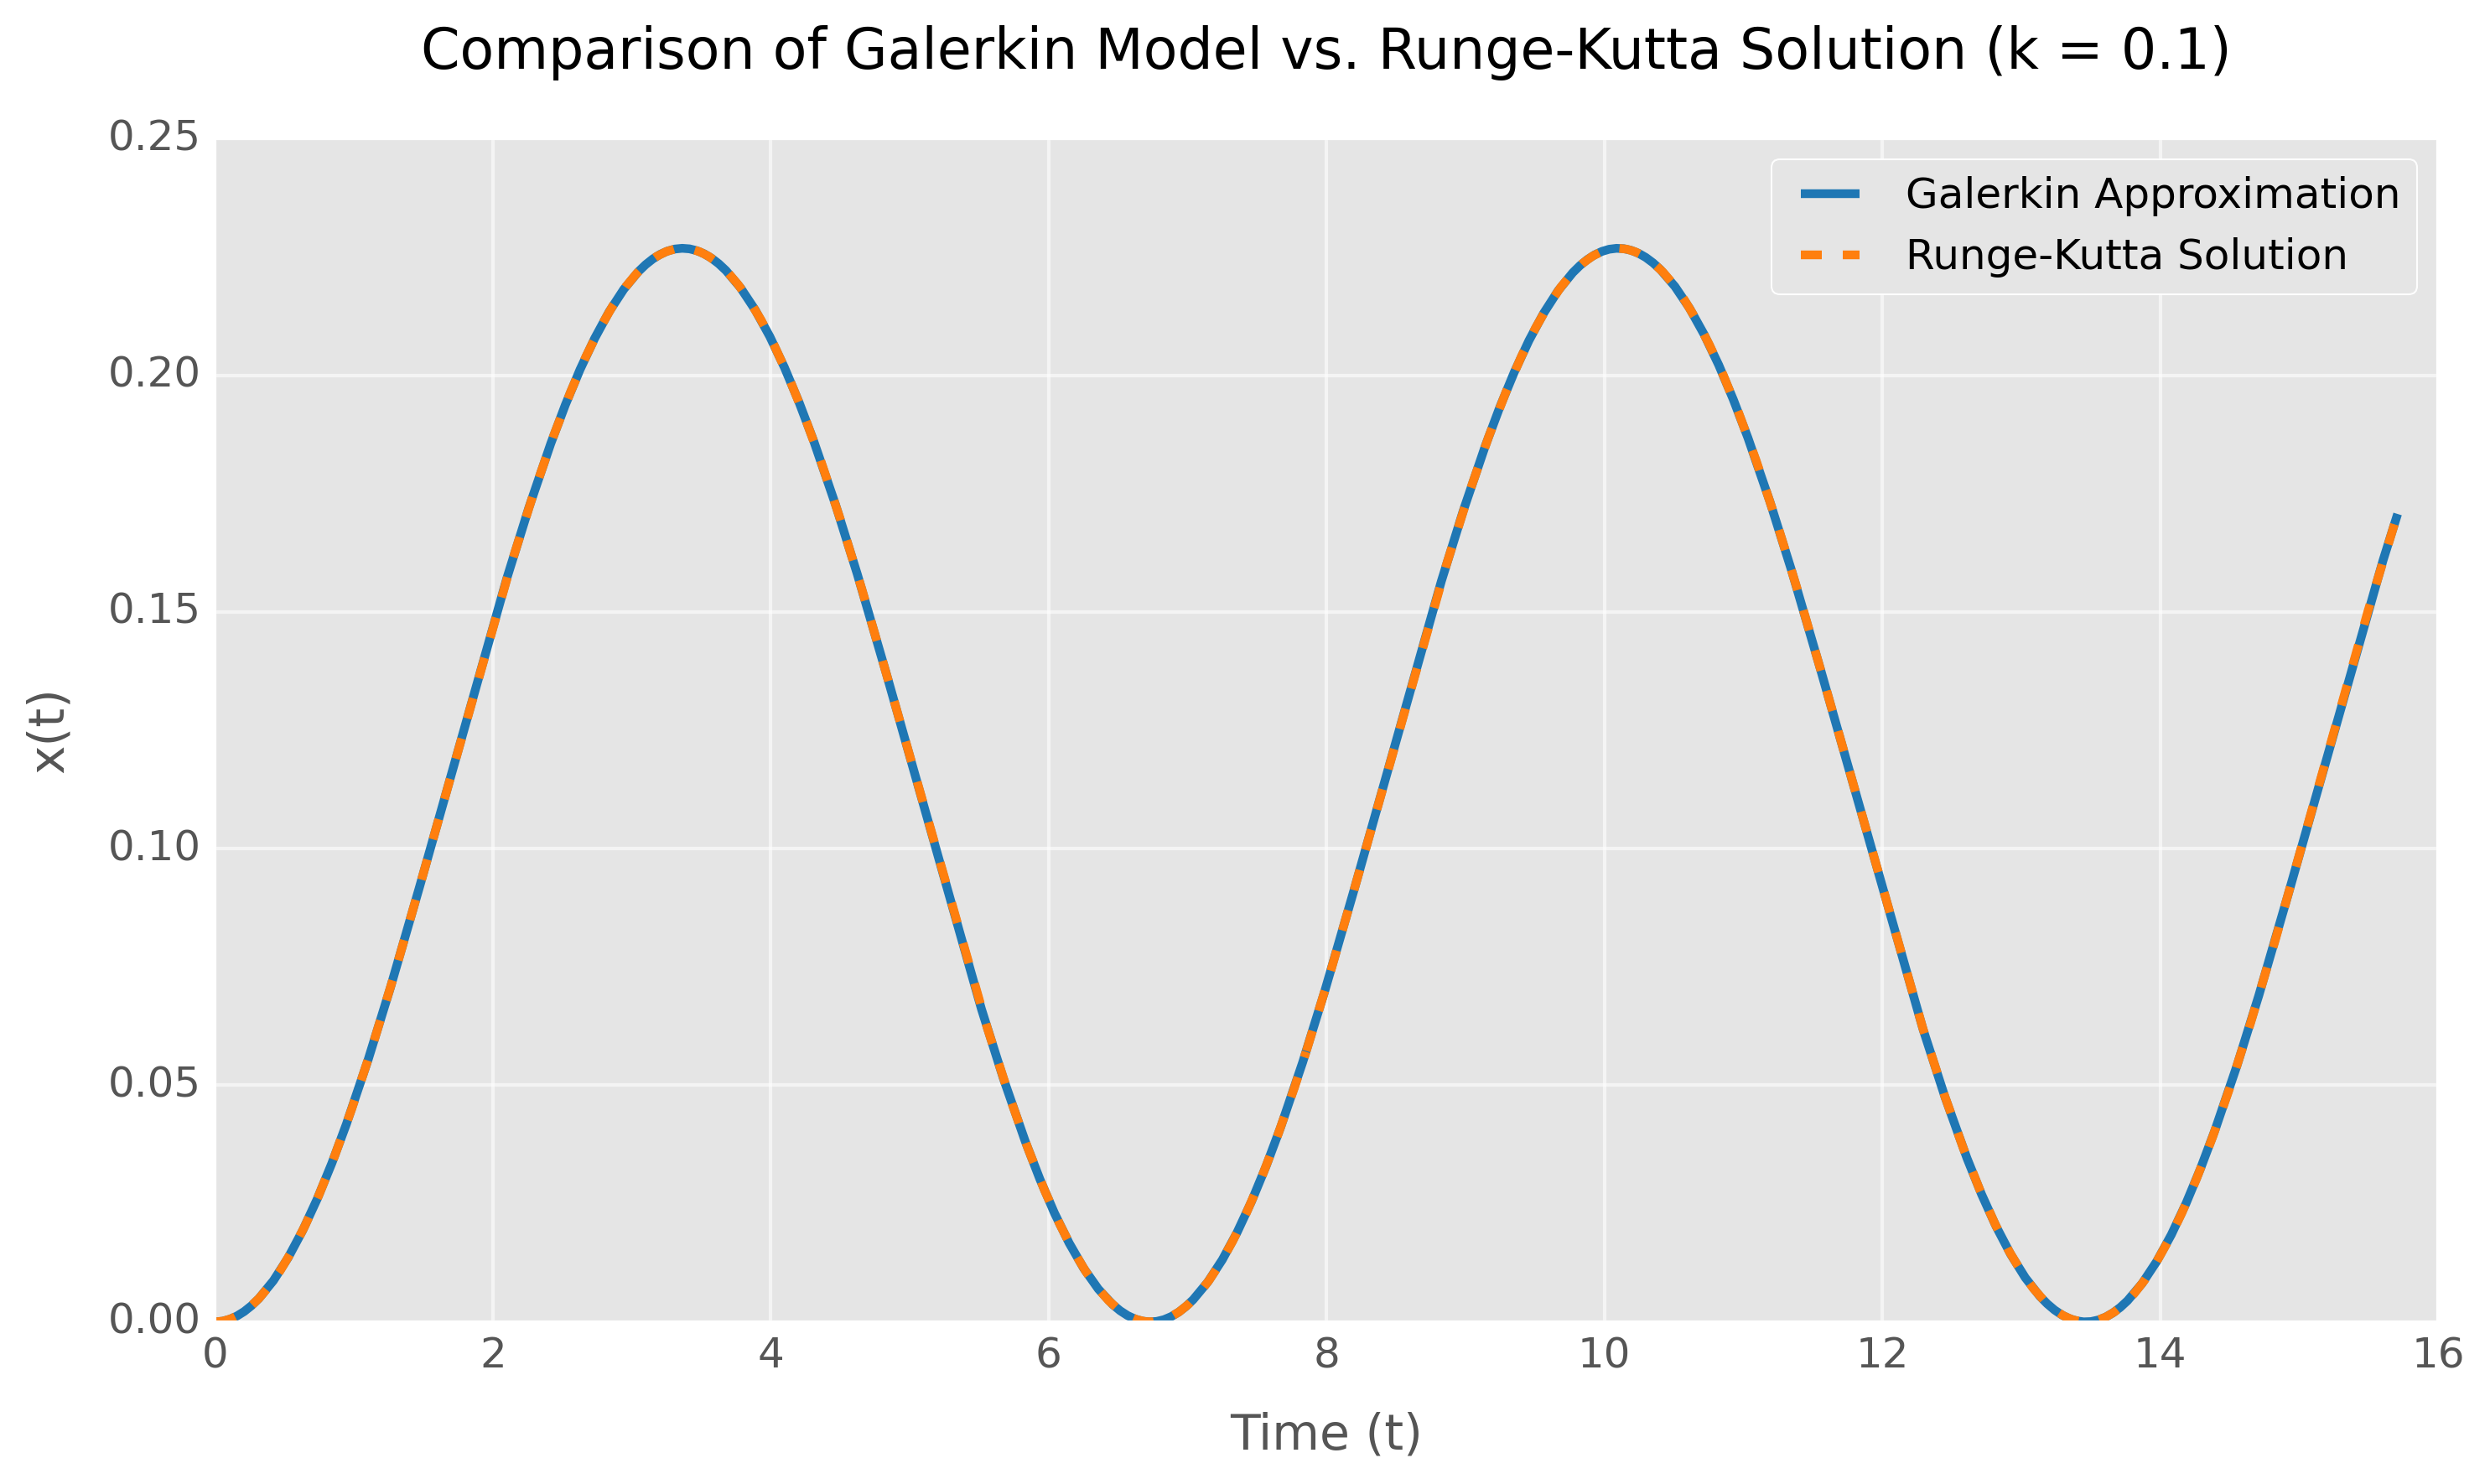

In [113]:
# Plot the comparison with high DPI and improved styling
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t_galerkin.cpu().numpy(), x_galerkin, 
         label="Galerkin Approximation", 
         linewidth=2.5,
         color='#1f77b4')
plt.plot(t_rk, x_rk, 
         label="Runge-Kutta Solution", 
         linestyle="--", 
         linewidth=2.5,
         color='#ff7f0e')

plt.xlabel("Time (t)", fontsize=14, labelpad=10)
plt.ylabel("x(t)", fontsize=14, labelpad=10)
plt.title(f"Comparison of Galerkin Model vs. Runge-Kutta Solution (k = {k_example})", 
          fontsize=16, pad=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, alpha=0.6)
plt.legend(fontsize=12, loc='upper right', framealpha=0.95)
plt.savefig('galerkin_vs_runge_kutta.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

In [106]:
# Fitting parameter dependence on k using Adam

k_star = 0.201
num_k = 50
karpathy_constant = 3e-4
file_path = 'theta_values.npz'

# Check if file exists and load if it does
if os.path.exists(file_path):
    print("Loading precomputed theta and k values...")
    data = np.load(file_path)
    theta_values = data['theta_values']
    k_values = data['k_values']
    print("Loaded theta and k values from theta_values.npz")
else:
    # If file doesn't exist, compute and save values
    k_values = np.linspace(0.002, k_star, num_k)
    theta_values = []

    print("\nOptimizing theta for different values of k...")
    for k_val in k_values:
        print(f"\nOptimizing theta for k = {k_val:.3f}...")
        theta_opt_k, _ = optimize_theta_for_k(k_val, n_iter=10000, lr=karpathy_constant, print_every=1000)
        theta_values.append(theta_opt_k.cpu().numpy())
    theta_values = np.array(theta_values)  # shape: (num_k, 4)

    # Save the theta values and k values to a numpy file
    np.savez(file_path, 
             theta_values=theta_values,
             k_values=k_values)
    print("Saved theta and k values to theta_values.npz")

Loading precomputed theta and k values...
Loaded theta and k values from theta_values.npz


In [107]:
class OmegaFit(nn.Module):
    def __init__(self):
        super().__init__()
        # We learn six parameters: a1, b1, c1, a2, b2, c2.
        self.a1, self.b1, self.c1, self.a2, self.b2, self.c2 = [
            nn.Parameter(torch.randn(1, device=device)) for _ in range(6)
        ]
    def forward(self, k):
        poly1 = self.a1 * k**2 + self.b1 * k + self.c1
        poly2 = self.a2 * k**2 + self.b2 * k + self.c2
        return torch.sqrt(torch.abs(poly1) + torch.sqrt(torch.abs(poly2)) + 1e-8)

class RatioFit(nn.Module):
    def __init__(self):
        super().__init__()
        # We learn six parameters: a1, b1, c1, a2, b2, c2.
        self.a1, self.b1, self.c1, self.a2, self.b2, self.c2 = [
            nn.Parameter(torch.randn(1, device=device)) for _ in range(6)
        ]
    def forward(self, k):
        num = self.a1 * k**2 + self.b1 * k + self.c1
        den = self.a2 * k**2 + self.b2 * k + self.c2 + 1e-8
        return num / den

class ExpFit(nn.Module):
    def __init__(self, sign=1.0):
        super().__init__()
        self.sign = sign
        # We learn six parameters: a1, b1, c1, d1, e1, f1.
        self.a1, self.b1, self.c1, self.d1, self.e1, self.f1 = [
            nn.Parameter(torch.randn(1, device=device)) for _ in range(6)
        ]
    def forward(self, k):
        poly = self.a1 * k**2 + self.b1 * k + self.c1
        expo = torch.exp(self.d1 * k**2 + self.e1 * k + self.f1)
        return self.sign * poly * expo

In [ ]:
# Run this cell to fit the models
# If you have the weights saved, you can run the next cell to plot the results

k_tensor = torch.tensor(k_values, device=device).unsqueeze(1)  # (num_k,1)
theta_tensor = torch.tensor(theta_values, device=device)       # (num_k,4)

# Create separate fitting modules for ω, α, β, γ (same as before)
omega_model = OmegaFit().to(device)
alpha_model = RatioFit().to(device)
beta_model  = ExpFit(sign=1.0).to(device)
gamma_model = ExpFit(sign=-1.0).to(device)

# Set up Adam optimizers for each model
optimizer_omega = optim.Adam(omega_model.parameters(), lr=1e-2)
optimizer_alpha = optim.Adam(alpha_model.parameters(), lr=1e-2)
optimizer_beta  = optim.Adam(beta_model.parameters(), lr=1e-2)
optimizer_gamma = optim.Adam(gamma_model.parameters(), lr=1e-2)

# We track models, their optimizers, which column of theta they correspond to, and a loss history
models = [
    ("omega",  omega_model,  optimizer_omega,  0, []),
    ("alpha",  alpha_model,  optimizer_alpha,  1, []),
    ("beta",   beta_model,   optimizer_beta,   2, []),
    ("gamma",  gamma_model,  optimizer_gamma,  3, []),
]

best_loss_for_model = [float('inf')] * len(models)
best_state_for_model = [None] * len(models)

schedulers = [
    optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    for _, _, opt, _, _ in models
]

n_epochs = 500_000
patience = 10_000
epochs_without_improvement = 0
lowest_overall_loss_sum = float('inf')

for epoch in range(1, n_epochs + 1):
    for _, _, opt, _, _ in models:
        opt.zero_grad()

    predictions = []
    for _, mdl, _, _, _ in models:
        pred = mdl(k_tensor).squeeze(1)
        predictions.append(pred)

    losses = []
    for i, (name, mdl, opt, col_idx, hist) in enumerate(models):
        true_vals = theta_tensor[:, col_idx]
        loss = torch.mean((predictions[i] - true_vals) ** 2)
        loss.backward(retain_graph=True)  # retain_graph needed if multiple dependencies
        hist.append(loss.item())
        losses.append(loss.item())

        # Track best state for each individual model
        if loss.item() < best_loss_for_model[i]:
            best_loss_for_model[i] = loss.item()
            best_state_for_model[i] = mdl.state_dict()

    # Step each optimizer
    for i, (_, _, opt, _, _) in enumerate(models):
        opt.step()

    # Step scheduler (if using)
    for i, sched in enumerate(schedulers):
        sched.step(losses[i])

    current_sum_of_losses = sum(losses)
    if current_sum_of_losses < lowest_overall_loss_sum:
        lowest_overall_loss_sum = current_sum_of_losses

        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epoch % 1000 == 0:
        print(
            f"Epoch {epoch:4d}: "
            + ", ".join(
                f"loss_{m[0]}={l:.4e}" for m, l in zip(models, losses)
            )
        )

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to lack of improvement.")
        break

for i, (name, mdl, opt, col_idx, hist) in enumerate(models):
    if best_state_for_model[i] is not None:
        mdl.load_state_dict(best_state_for_model[i])
    print(f"Best loss for {name} = {best_loss_for_model[i]:.4e}")

In [121]:
MODEL_DIR = "saved_models"

OMEGA_PATH, ALPHA_PATH, BETA_PATH, GAMMA_PATH, PARAMS_PATH = [
    os.path.join(MODEL_DIR, name) for name in (
        "omega_model.pt",
        "alpha_model.pt",
        "beta_model.pt",
        "gamma_model.pt",
        "params.json"
    )
]

def save_models_and_params():
    os.makedirs(MODEL_DIR, exist_ok=True)
    for model, path in [
        (omega_model, OMEGA_PATH),
        (alpha_model, ALPHA_PATH),
        (beta_model, BETA_PATH),
        (gamma_model, GAMMA_PATH)
    ]:
        torch.save(model.state_dict(), path)
    def gather_params(m, p_list):
        return {p: float(getattr(m, p).item()) for p in p_list}
    params = {
        "omega_model": gather_params(omega_model, ["a1","b1","c1","a2","b2","c2"]),
        "alpha_model": gather_params(alpha_model, ["a1","b1","c1","a2","b2","c2"]),
        "beta_model":  gather_params(beta_model,  ["a1","b1","c1","d1","e1","f1"]),
    }
    with open(PARAMS_PATH, "w") as f:
        json.dump(params, f, indent=4)
    print("Models and parameters have been saved.")

def load_models_and_params():
    needed_files = [OMEGA_PATH, ALPHA_PATH, BETA_PATH, GAMMA_PATH, PARAMS_PATH]
    if not all(os.path.exists(f) for f in needed_files):
        return False
    try:
        for model, path in [
            (omega_model, OMEGA_PATH),
            (alpha_model, ALPHA_PATH),
            (beta_model, BETA_PATH),
            (gamma_model, GAMMA_PATH)
        ]:
            model.load_state_dict(torch.load(path))
        with open(PARAMS_PATH, "r") as f:
            params = json.load(f)
        print(params)
        print("Models and parameters have been loaded from file.")
        return True
    except Exception as e:
        print(f"Error loading models: {e}")
        return False

if not load_models_and_params():
    save_models_and_params()

{'omega_model': {'a1': 3.5402834570487522, 'b1': -0.69091264855154, 'c1': 0.033646089296846954, 'a2': 2.0250132427426277, 'b2': -0.21162282000838456, 'c2': -0.04711956321875086}, 'alpha_model': {'a1': 8.350146959850766, 'b1': -2.9861479351268785, 'c1': 0.001699190439502104, 'a2': 1.1296020265541802, 'b2': 4.833970848697528, 'c2': -1.436870529623911}, 'beta_model': {'a1': 6.942818647417846, 'b1': -2.6647168571187856, 'c1': 0.2848969724088576, 'd1': 62.728428152058534, 'e1': 32.28156981540869, 'f1': -8.496100317806176}}
Models and parameters have been loaded from file.


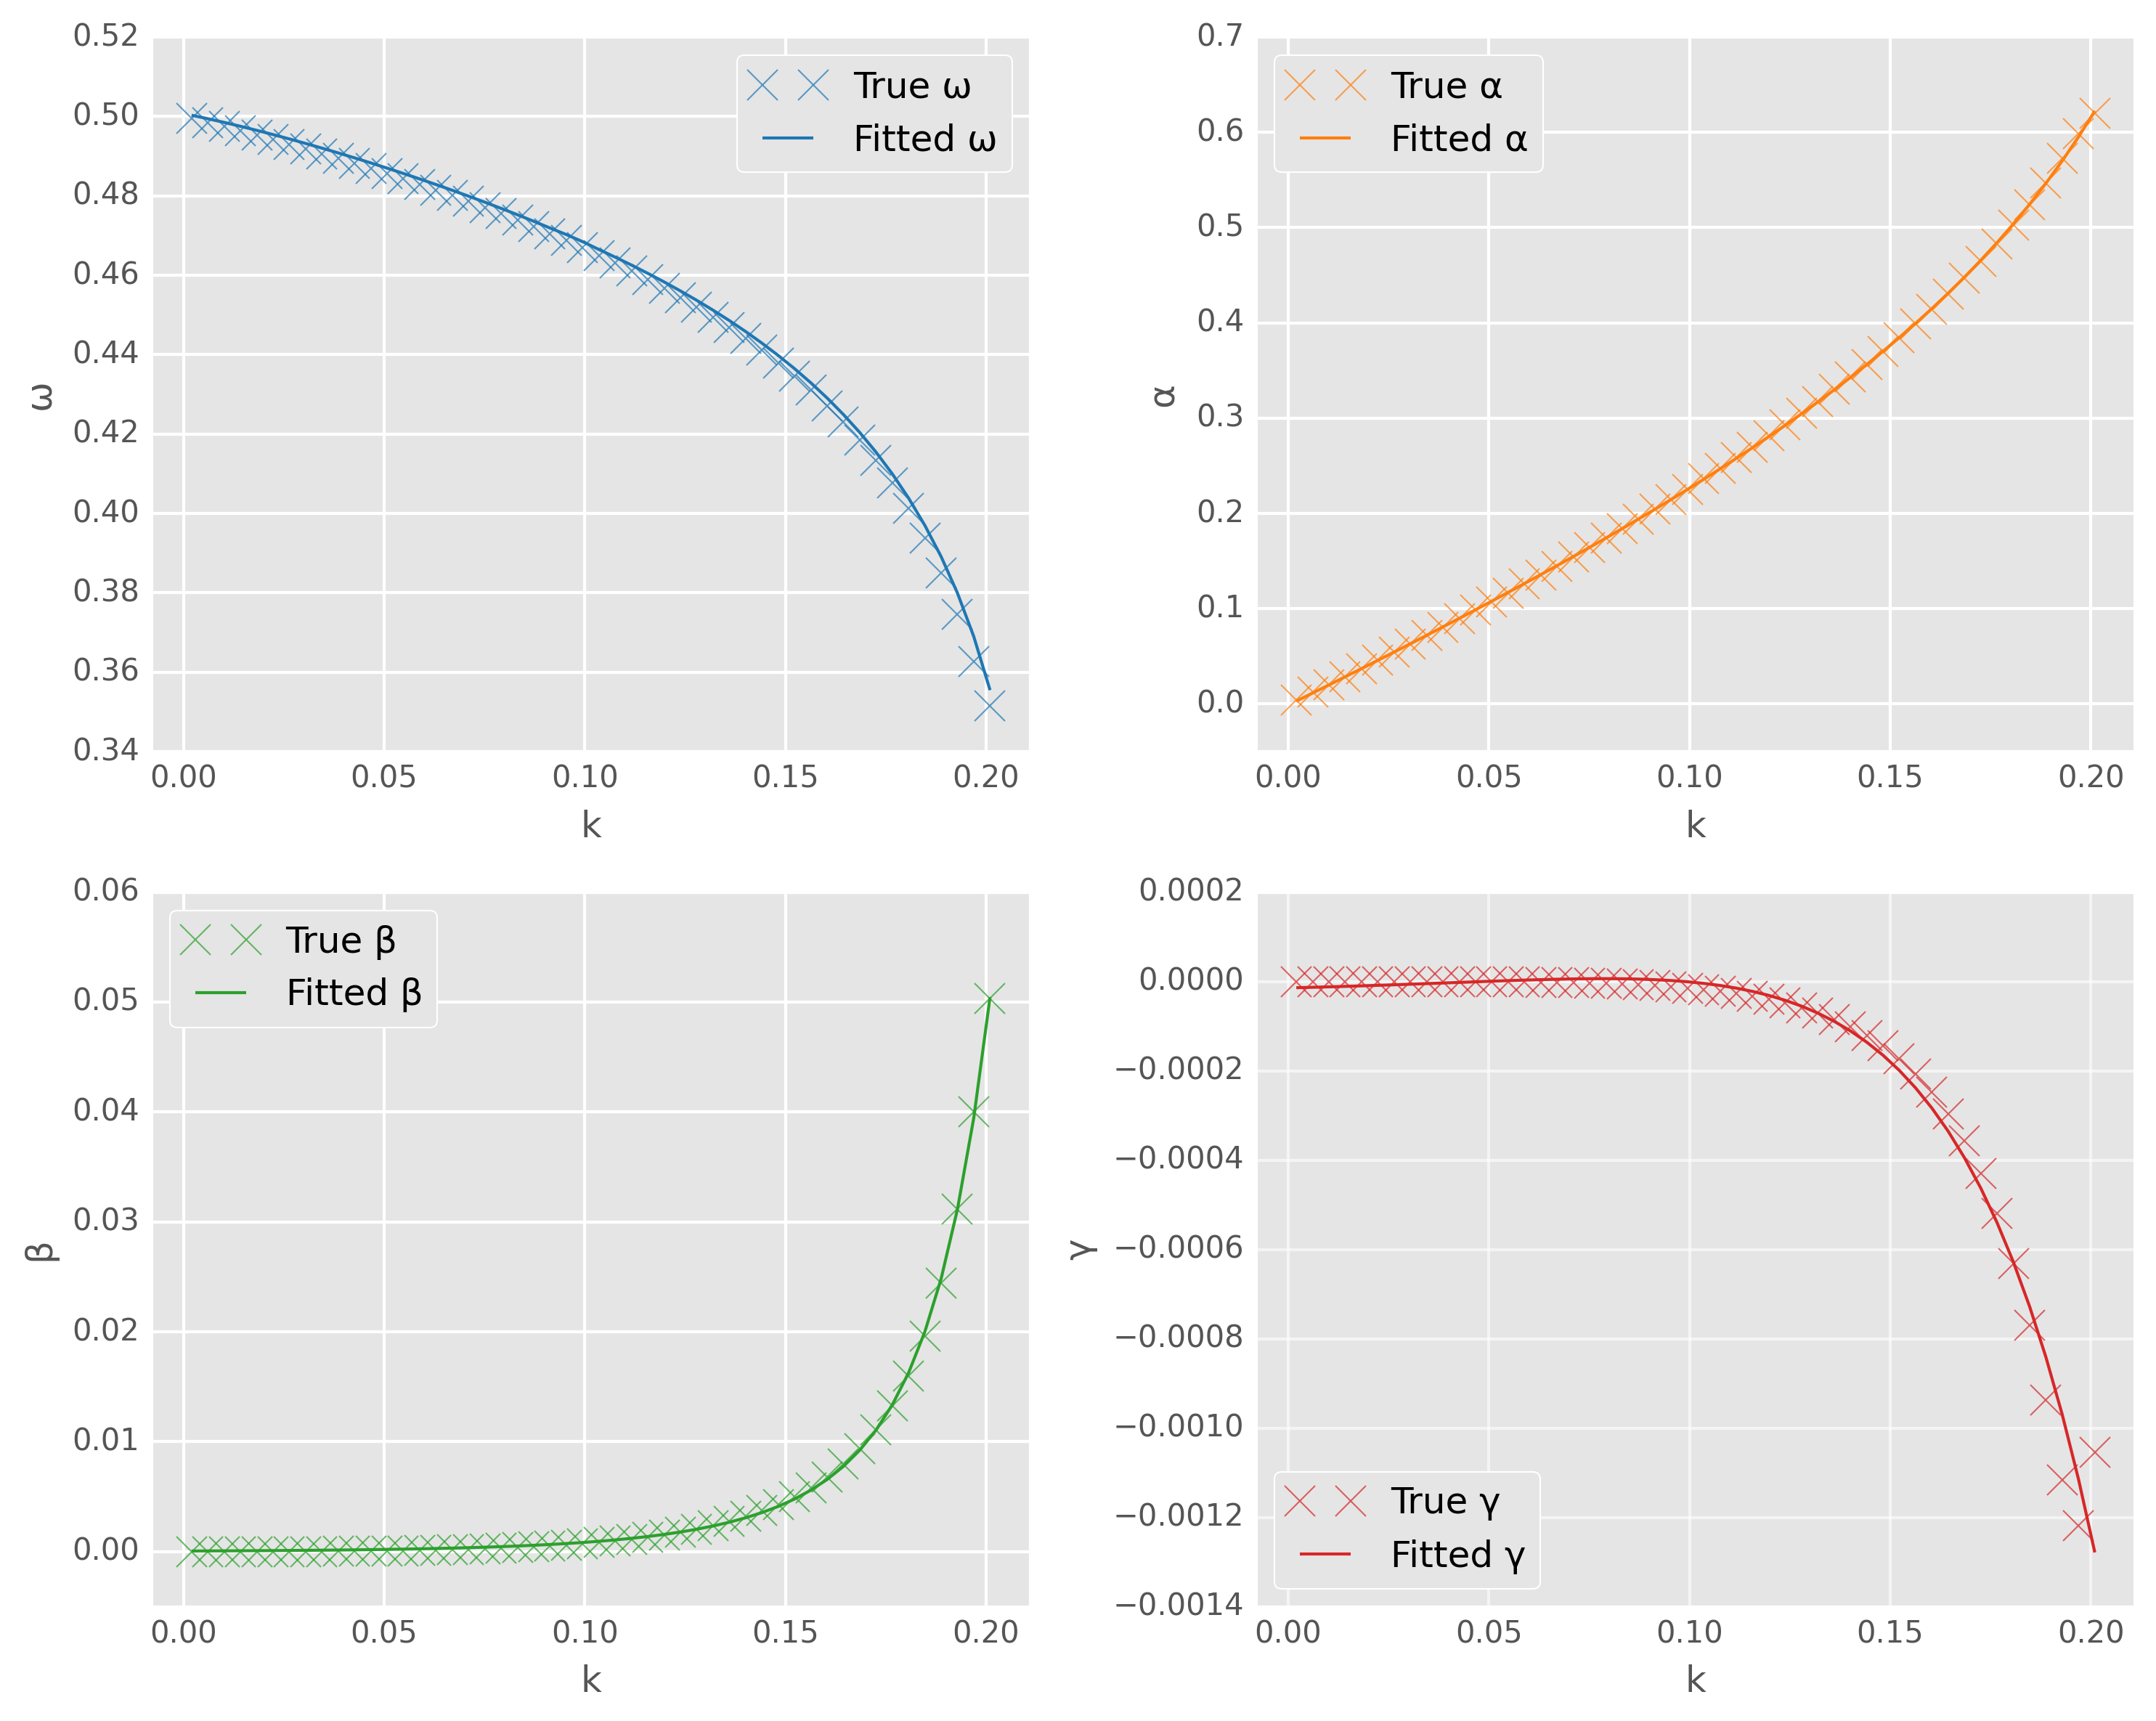


Fitted parameters for ω(k):
a1 = 3.54028, b1 = -0.69091, c1 = 0.03365, a2 = 2.02501, b2 = -0.21162, c2 = -0.04712, 

Fitted parameters for α(k):
a1 = 8.35015, b1 = -2.98615, c1 = 0.00170, a2 = 1.12960, b2 = 4.83397, c2 = -1.43687, 

Fitted parameters for β(k):
a1 = 6.94282, b1 = -2.66472, c1 = 0.28490, d1 = 62.72843, e1 = 32.28157, f1 = -8.49610, 

Fitted parameters for γ(k):
a1 = 3.68716, b1 = -0.54493, c1 = 0.01791, d1 = 3.21669, e1 = 15.83239, f1 = -7.11563, 


In [118]:
# Plot the fit for each parameter vs. k.
plt.figure(figsize=(10, 8), dpi=300)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['ω', 'α', 'β', 'γ']
models = [omega_model, alpha_model, beta_model, gamma_model]

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(k_values, theta_tensor[:,i].cpu().numpy(), 'x', alpha=0.7, 
             label=f'True {labels[i]}', markersize=10, color=colors[i])
    plt.plot(k_values, models[i](k_tensor).detach().cpu().numpy(), '-', 
             color=colors[i], label=f'Fitted {labels[i]}', linewidth=1)
    plt.xlabel('k')
    plt.ylabel(labels[i])
    plt.xlim(min(k_values) - 0.01, max(k_values) + 0.01)
    if i == 1:
        plt.ylim(-0.05, 0.7)
    elif i == 2:
        plt.ylim(-0.005, 0.06)
    plt.legend(loc='best')

plt.tight_layout()
plt.grid(True, alpha=0.6)
plt.savefig('parameters_fit.png', bbox_inches='tight', dpi=300)
plt.show()

# Print learned parameters
model_params = {
    'ω(k)': omega_model,
    'α(k)': alpha_model,
    'β(k)': beta_model,
    'γ(k)': gamma_model
}

for name, model in model_params.items():
    print(f"\nFitted parameters for {name}:")
    for param in model.state_dict():
        print(f"{param} = {getattr(model, param).item():.5f}", end=', ')
    print()